In [1]:
import gymnasium as gym
from gymnasium import RewardWrapper
import pygame
import sys
import os
frozen_lake2_path = os.path.abspath("../../gym_grid_world_tutorial")
sys.path.append(frozen_lake2_path)
from frozen_lake2 import FrozenLake2Env 
from typing import Optional

from pathlib import Path
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from plot_utils import plot_env, plot_env_coords, plot_val, plot_val_coords, set_savefig_folder


class Params(NamedTuple):
    total_episodes: int  # Total episodes
    learning_rate: float  # Learning rate
    gamma: float  # Discounting rate
    epsilon: float  # Exploration probability
    map_row_size: int  # Number of rows of the environment
    map_col_size: int # Number of columns of the environment
    seed: int  # Define a seed so that we get reproducible results
    is_slippery: bool  # If true the player will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions
    n_runs: int  # Number of runs
    action_size: int  # Number of possible actions
    state_size: int  # Number of possible states
    proba_frozen: float  # Probability that a tile is frozen
    savefig_folder: Path  # Root folder where plots are saved

In [2]:
desc = ["FFFG","FBFH","SFFF"]
env = FrozenLake2Env(
    render_mode="rgb_array", 
    desc=desc, 
    map_name="3x4", 
    is_slippery=False)
print(f"Action space: {env.action_space}")
print(f"State space: {env.observation_space}")

env.reset()

params = Params(
    total_episodes=2000,
    learning_rate=0.8,
    gamma=0.95,
    epsilon=0.1,
    map_row_size=len(desc),
    map_col_size=len(desc[0]),
    seed=123,
    is_slippery=False,
    n_runs=20,
    action_size=None,
    state_size=None,
    proba_frozen=0.1,
    savefig_folder=Path("./img/step_by_step_tutorial/")
)

# Create the figure folder if it doesn't exists
params.savefig_folder.mkdir(parents=True, exist_ok=True)
set_savefig_folder(params.savefig_folder)

Action space: Discrete(4)
State space: Discrete(12)


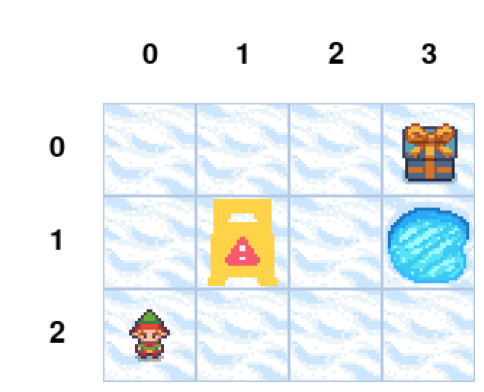

In [3]:
plot_env_coords(env)

In [4]:
desc2 = ["FFFFFFG","BFFBBFH","SFFFFFF","FFHHHHH"]
env2 = FrozenLake2Env(
    render_mode="rgb_array", 
    desc=desc2, 
    map_name="4x7", 
    is_slippery=False)
print(f"Action space: {env2.action_space}")
print(f"State space: {env2.observation_space}")

env2.reset()

Action space: Discrete(4)
State space: Discrete(28)


(14, {'prob': 1})

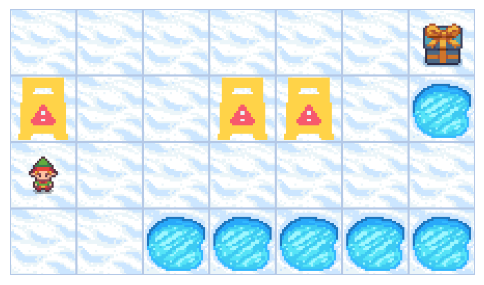

In [5]:
plot_env(env2)

In [6]:
vbounds = (-1.,1.)

In [7]:
def rewards_ft(cell_type):
    if cell_type == b"H":
        return -1.0
    elif cell_type == b"G":
        return 1.0
    else:
        return 0.0

def rewards_f(row:int, col:int):
    cell_type = env.desc[row,col]
    return rewards_ft(cell_type)

In [8]:
def rewards_f2(row:int, col:int):
    cell_type = env2.desc[row,col]
    return rewards_ft(cell_type)

In [9]:
print([rewards_f2(r,6) for r in range(4)])

[1.0, -1.0, 0.0, -1.0]


In [28]:
def transition_determinist(coords,action,next_coords) -> float:
    next = env.transition_coordinates(coords[0],coords[1],action)
    return 1.0 if next == next_coords else 0.0

def transition_determinist2(coords,action,next_coords) -> float:
    next = env2.transition_coordinates(coords[0],coords[1],action)
    return 1.0 if next == next_coords else 0.0

def transition_non_determinist(coords, action, next_coords) -> float:
    next = env2.transition_coordinates(coords[0], coords[1], action)
    if env2.is_blocked_coordinates(next[0], next[1]):
        return 0.0
    
    actions = set([0, 1, 2, 3])
    
    valid_next_coord = []
    valid_next_coord.append(coords)

    for a in actions:
        new = env2.transition_coordinates(coords[0], coords[1], a)
        if new != coords:
            valid_next_coord.append(new)
    
    valid_next_coord = list(set(valid_next_coord))
    nb_valid_next_coord = len(valid_next_coord) - 1

    if next == next_coords:
        return 0.8
    elif next_coords in valid_next_coord:
        return 0.2 / nb_valid_next_coord
    else:
        return 0.0
    
    

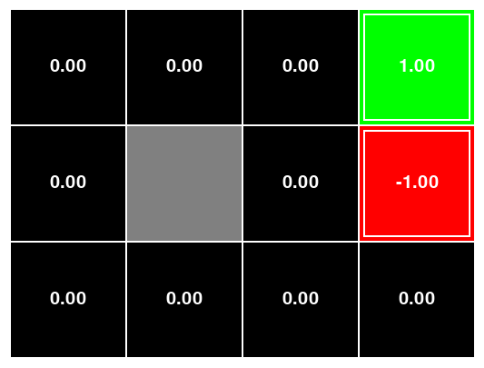

In [29]:
from rl_agent import RlAgent
agent = RlAgent(env,rewards_ft,vbounds,transition_non_determinist,gamma=0.9)
agent.init_values_2_tabs()
agent.compute_next_values()
plot_val(env=env,values=agent.values,minmax=vbounds)

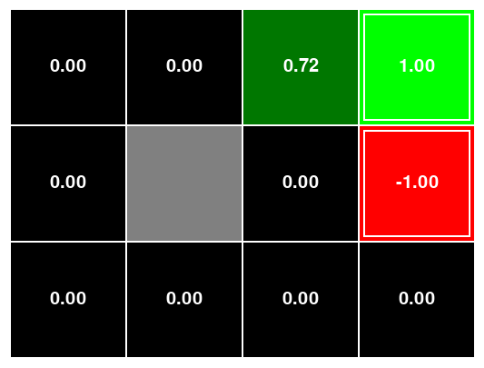

In [30]:
agent.compute_next_values()
plot_val(env=env,values=agent.values,minmax=vbounds)

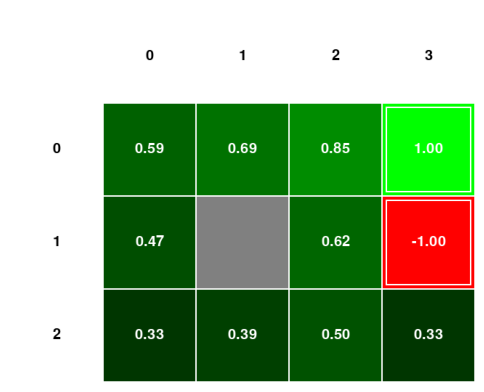

In [31]:
for i in range(10):
    agent.compute_next_values()
plot_val_coords(env=env,values=agent.values,minmax=vbounds)

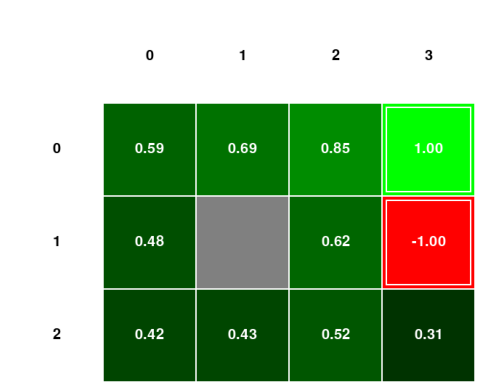

In [24]:
plot_val_coords(env=env,values=agent.values,minmax=vbounds)

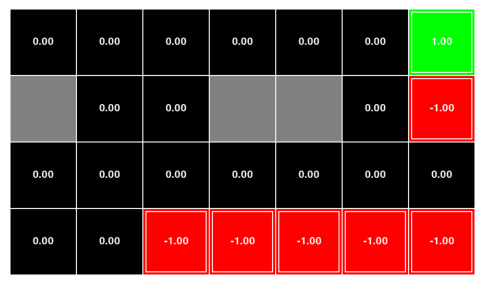

In [32]:
agent2 = RlAgent(env2,rewards_ft,vbounds,transition_non_determinist,gamma=0.9)
agent2.init_values_2_tabs()
agent2.compute_next_values()
plot_val(env=env2,values=agent2.values,minmax=vbounds)

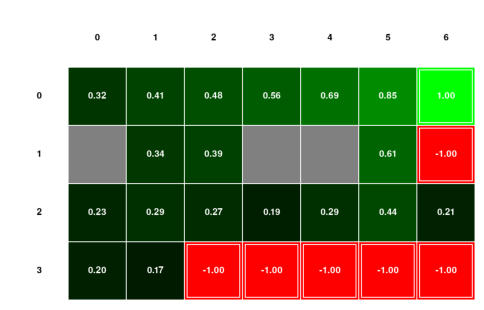

In [35]:
for i in range(10):
    agent2.compute_next_values()
plot_val_coords(env=env2,values=agent2.values,minmax=vbounds)

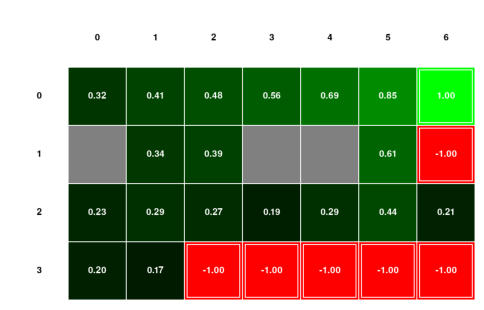

In [36]:
plot_val_coords(env=env2,values=agent2.values,minmax=vbounds)